In [19]:
rm(list = ls())
library(LalRUtils)
libreq(data.table, tidyverse, anytime, patchwork, plotly, broom, zoo)
theme_set(lal_plot_theme_d())

options(repr.plot.width = 15, repr.plot.height = 12)

     wants        loaded
[1,] "data.table" TRUE  
[2,] "tidyverse"  TRUE  
[3,] "anytime"    TRUE  
[4,] "patchwork"  TRUE  
[5,] "plotly"     TRUE  
[6,] "broom"      TRUE  
[7,] "zoo"        TRUE  


# Covidtracking Project data viz
https://covidtracking.com/api

In [20]:
ctracking_url = "http://covidtracking.com/api/states/daily.csv"
state_tests = fread(ctracking_url)
state_tests[, d := anydate(date)]
state_tests[, day := weekdays(d)]
dropcols = c('hash', 'dateChecked')
state_tests[, (dropcols) := NULL]
state_tests %>% glimpse()

Rows: 2,881
Columns: 25
$ date                     <int> 20200425, 20200425, 20200425, 20200425, 2020…
$ state                    <chr> "AK", "AL", "AR", "AS", "AZ", "CA", "CO", "C…
$ positive                 <int> 339, 6137, 2829, 0, 6280, 41137, 12256, 2458…
$ negative                 <int> 15393, 65207, 35224, 3, 56228, 464898, 44533…
$ pending                  <int> NA, NA, NA, 17, NA, NA, NA, NA, NA, NA, 1292…
$ hospitalizedCurrently    <int> 32, NA, 104, NA, 697, 4847, 1084, 1810, 402,…
$ hospitalizedCumulative   <int> NA, 839, 291, NA, 1022, NA, 2366, NA, NA, NA…
$ inIcuCurrently           <int> NA, NA, NA, NA, 313, 1458, NA, NA, 120, NA, …
$ inIcuCumulative          <int> NA, 288, NA, NA, NA, NA, NA, NA, NA, NA, NA,…
$ onVentilatorCurrently    <int> NA, NA, 25, NA, 191, NA, NA, NA, 69, NA, NA,…
$ onVentilatorCumulative   <int> NA, 170, 57, NA, NA, NA, NA, NA, NA, NA, NA,…
$ recovered                <int> 217, NA, 964, NA, 1345, NA, 2086, NA, 652, 8…
$ death                    <

In [21]:
state_tests[, tpr := positive / totalTestResults]
state_tests[, tpr_new := positiveIncrease / totalTestResultsIncrease]
(most_affected = 
     state_tests[d == max(state_tests$d)][
    order(-positive)][
    1:10])

date     state positive negative pending hospitalizedCurrently
1  20200425 NY    282143   495425     NA    13524                
2  20200425 NJ    105523   108163     NA     6722                
3  20200425 MA     53348   173497     NA     3847                
4  20200425 IL     41777   159840     NA     4699                
5  20200425 CA     41137   464898     NA     4847                
6  20200425 PA     40049   152886     NA     2748                
7  20200425 MI     37203   106841     NA     2889                
8  20200425 FL     30839   302260   1292       NA                
9  20200425 LA     26512   112490     NA     1700                
10 20200425 CT     24582    53020     NA     1810                
   hospitalizedCumulative inIcuCurrently inIcuCumulative onVentilatorCurrently
1  57103                  5016           NA                NA                 
2     NA                  1971           NA              1442                 
3   4965                  1058           NA                NA                 
4     NA                  1244           NA               763                 
5     NA                  1458           NA                NA                 
6     NA                    NA           NA               640                 
7     NA                  1164           NA               934                 
8   5045                    NA           NA                NA                 
9     NA                    NA           NA               268                 
10    NA                    NA           NA                NA                 
   ⋯ fips deathIncrease hospitalizedIncrease negativeIncrease positiveIncrease
1  ⋯ 36   437             0                  36359            10553           
2  ⋯ 34   246             0                   4397             3327           
3  ⋯ 25   370           472                  24444             7325           
4  ⋯ 17    79             0                   9866             2119           
5  ⋯  6    89             0                   9979             1883           
6  ⋯ 42    45             0                   5395             1397           
7  ⋯ 26   189             0                   7186              562           
8  ⋯ 12    44           157                  15475              665           
9  ⋯ 22    43             0                  -5086              372           
10 ⋯  9    98             0                   2903              661           
   totalTestResultsIncrease d          day      tpr     tpr_new 
1  46912                    2020-04-25 Saturday 0.36285  0.22495
2   7724                    2020-04-25 Saturday 0.49382  0.43074
3  31769                    2020-04-25 Saturday 0.23517  0.23057
4  11985                    2020-04-25 Saturday 0.20721  0.17680
5  11862                    2020-04-25 Saturday 0.08129  0.15874
6   6792                    2020-04-25 Saturday 0.20758  0.20568
7   7748                    2020-04-25 Saturday 0.25828  0.07253
8  16140                    2020-04-25 Saturday 0.09258  0.04120
9  -4714                    2020-04-25 Saturday 0.19073 -0.07891
10  3564                    2020-04-25 Saturday 0.31677  0.18547

In [22]:
t10states = state_tests[positive >= 10 & state %in% most_affected$state]

In [23]:
setorder(t10states, state, date)

smoothvars = c("positive", "hospitalized", "death", "totalTestResults", 
              "positiveIncrease", "hospitalizedIncrease", "deathIncrease", "totalTestResultsIncrease",
              'tpr', 'tpr_new')

t10states[, paste0("rm3_", smoothvars) := lapply(.SD, rollmean, k = 3, fill = NA, na.pad = T), 
   by = .(state), .SDcols = smoothvars]

# t10states[, tpr_rm3 := rollmeanr(tpr, 3, fill = NA), by = .(state)]

# Plots 

In [24]:
# generic function to plot time series
plot_ts = function(df, col, t = "Time Series of", logtransform = F){
    p = ggplot(df, aes(x = d, colour = state, group = state)) +
        geom_point(aes_string(y = col), size = 0.7) + geom_line(aes_string(y = paste0("rm3_", col))) +
        scale_colour_brewer(palette = "Spectral") +
        labs(
            title = t,
            subtitle = paste(unique(df$state), collapse = ", ")
        )
    if (logtransform == T) p = p + scale_y_log10()
    return(p)
}

## Cases 

Warning message:
“Removed 20 row(s) containing missing values (geom_path).”


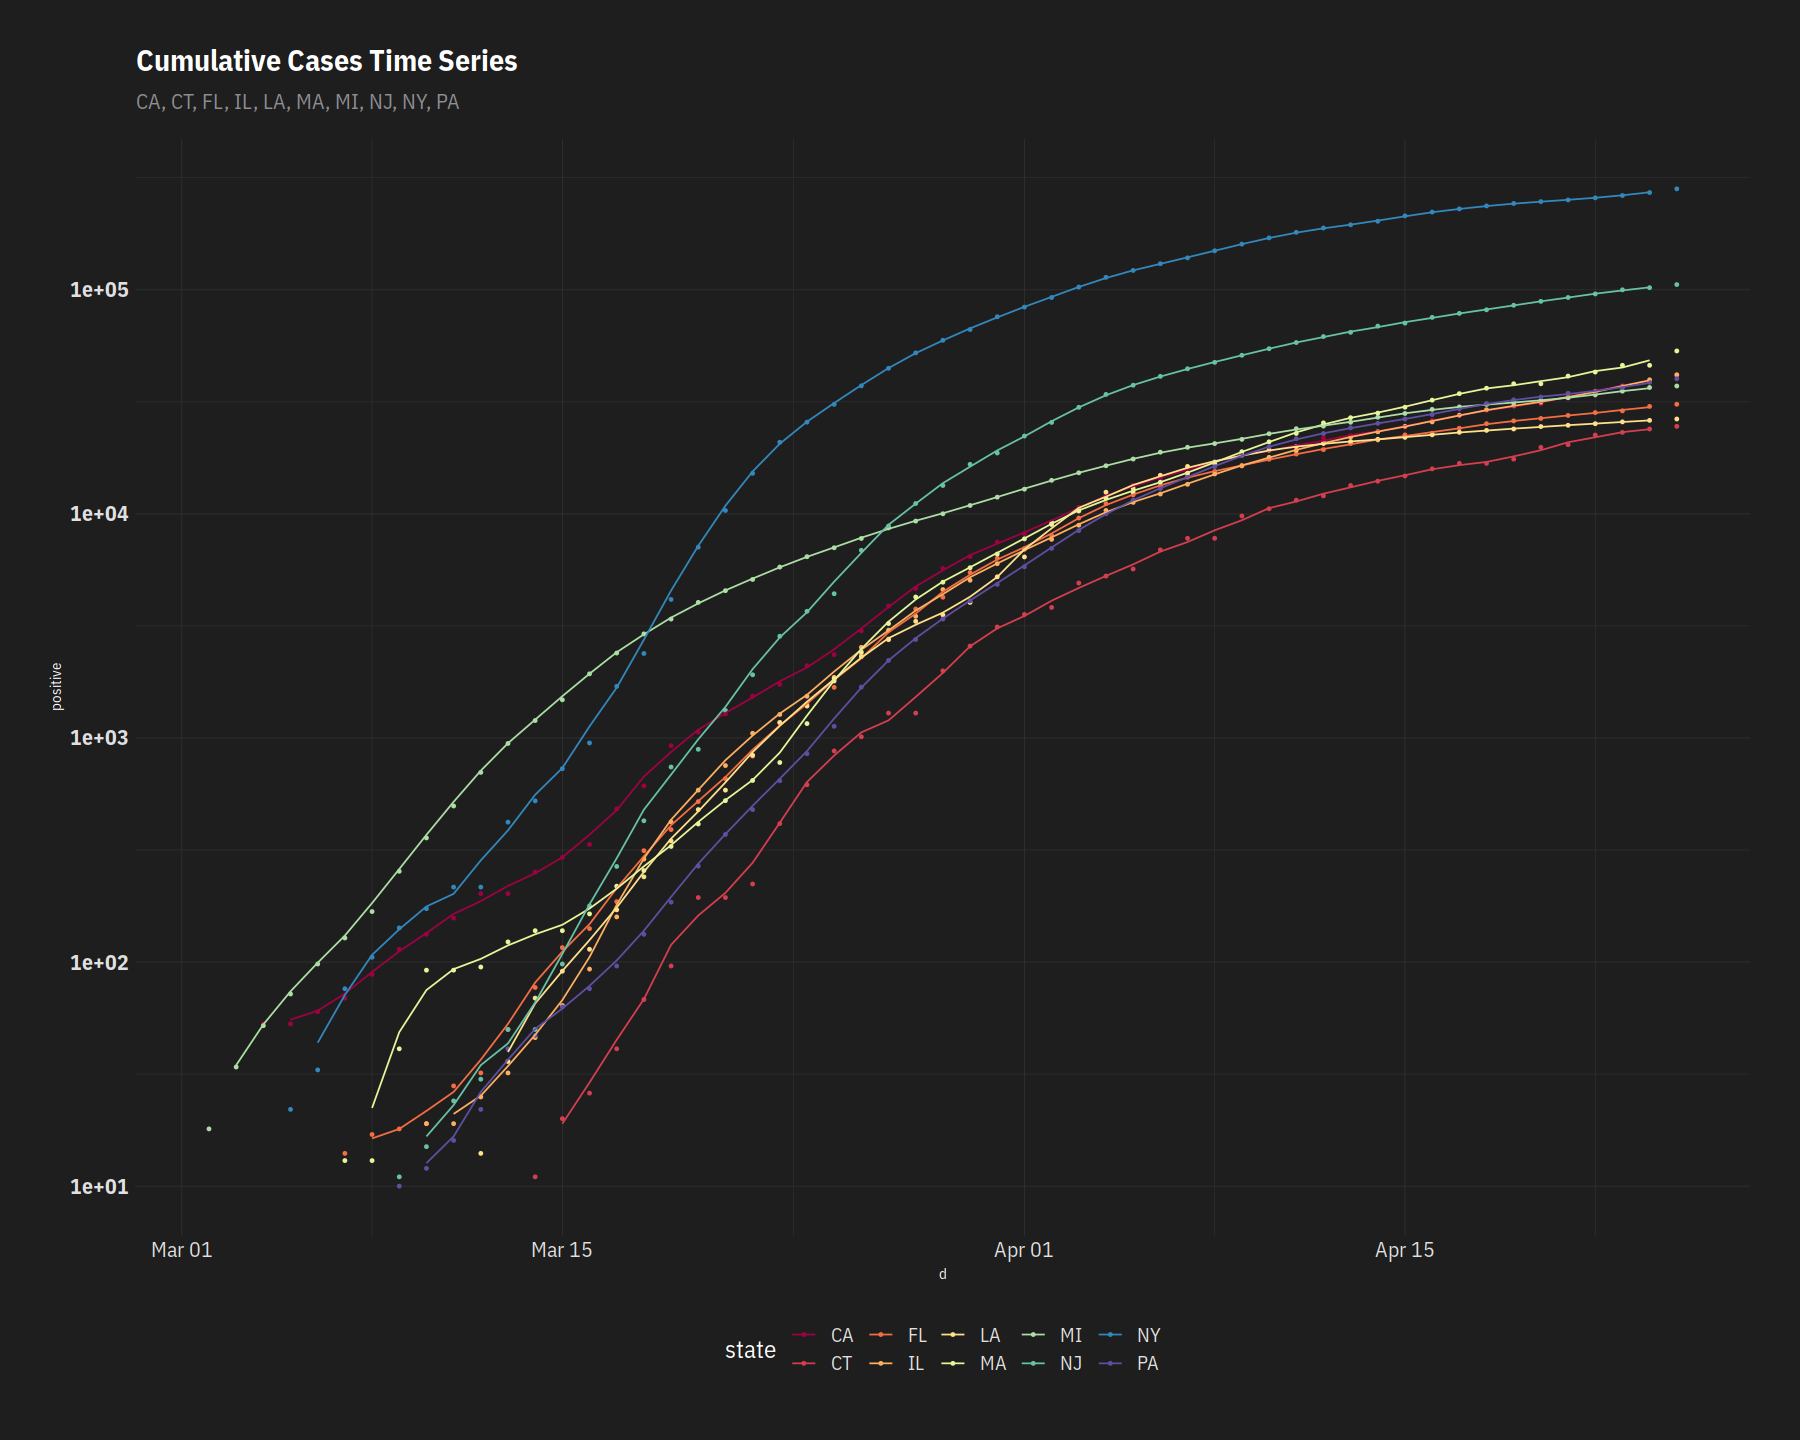

In [25]:
(p = plot_ts(t10states, 'positive', "Cumulative Cases Time Series", T))

In [26]:
embed_notebook(ggplotly(p))

<iframe src="data:text/html;charset=utf-8;base64,PCFET0NUWVBFIGh0bWw+CjxodG1sPgo8aGVhZD4KPG1ldGEgY2hhcnNldD0idXRmLTgiIC8+Cjx0aXRsZT5wbG90bHk8L3RpdGxlPgo8c2NyaXB0PihmdW5jdGlvbigpIHsKICAvLyBJZiB3aW5kb3cuSFRNTFdpZGdldHMgaXMgYWxyZWFkeSBkZWZpbmVkLCB0aGVuIHVzZSBpdDsgb3RoZXJ3aXNlIGNyZWF0ZSBhCiAgLy8gbmV3IG9iamVjdC4gVGhpcyBhbGxvd3MgcHJlY2VkaW5nIGNvZGUgdG8gc2V0IG9wdGlvbnMgdGhhdCBhZmZlY3QgdGhlCiAgLy8gaW5pdGlhbGl6YXRpb24gcHJvY2VzcyAodGhvdWdoIG5vbmUgY3VycmVudGx5IGV4aXN0KS4KICB3aW5kb3cuSFRNTFdpZGdldHMgPSB3aW5kb3cuSFRNTFdpZGdldHMgfHwge307CgogIC8vIFNlZSBpZiB3ZSdyZSBydW5uaW5nIGluIGEgdmlld2VyIHBhbmUuIElmIG5vdCwgd2UncmUgaW4gYSB3ZWIgYnJvd3Nlci4KICB2YXIgdmlld2VyTW9kZSA9IHdpbmRvdy5IVE1MV2lkZ2V0cy52aWV3ZXJNb2RlID0KICAgICAgL1xidmlld2VyX3BhbmU9MVxiLy50ZXN0KHdpbmRvdy5sb2NhdGlvbik7CgogIC8vIFNlZSBpZiB3ZSdyZSBydW5uaW5nIGluIFNoaW55IG1vZGUuIElmIG5vdCwgaXQncyBhIHN0YXRpYyBkb2N1bWVudC4KICAvLyBOb3RlIHRoYXQgc3RhdGljIHdpZGdldHMgY2FuIGFwcGVhciBpbiBib3RoIFNoaW55IGFuZCBzdGF0aWMgbW9kZXMsIGJ1dAogIC8vIG9idmlvdXNseSwgU2hpbnkgd2lkZ2V0cyBjYW4gb25seSBhcHBlYXIgaW4gU2hpbnkgYXBwcy9kb2N1bWVudHMuCiAgdmFyIHNoaW55TW9kZSA9IHdpbmRvdy5IVE1MV2lkZ2V0cy5zaGlueU1vZGUgPQogICAgICB0eXBlb2Yod2luZG93LlNoaW55KSAhPT0gInVuZGVmaW5lZCIgJiYgISF3aW5kb3cuU2hpbnkub3V0cHV0QmluZGluZ3M7CgogIC8vIFdlIGNhbid0IGNvdW50IG9uIGpRdWVyeSBiZWluZyBhdmFpbGFibGUsIHNvIHdlIGltcGxlbWVudCBvdXIgb3duCiAgLy8gdmVyc2lvbiBpZiBuZWNlc3NhcnkuCiAgZnVuY3Rpb24gcXVlcnlTZWxlY3RvckFsbChzY29wZSwgc2VsZWN0b3IpIHsKICAgIGlmICh0eXBlb2YoalF1ZXJ5KSAhPT0gInVuZGVmaW5lZCIgJiYgc2NvcGUgaW5zdGFuY2VvZiBqUXVlcnkpIHsKICAgICAgcmV0dXJuIHNjb3BlLmZpbmQoc2VsZWN0b3IpOwogICAgfQogICAgaWYgKHNjb3BlLnF1ZXJ5U2VsZWN0b3JBbGwpIHsKICAgICAgcmV0dXJuIHNjb3BlLnF1ZXJ5U2VsZWN0b3JBbGwoc2VsZWN0b3IpOwogICAgfQogIH0KCiAgZnVuY3Rpb24gYXNBcnJheSh2YWx1ZSkgewogICAgaWYgKHZhbHVlID09PSBudWxsKQogICAgICByZXR1cm4gW107CiAgICBpZiAoJC5pc0FycmF5KHZhbHVlKSkKICAgICAgcmV0dXJuIHZhbHVlOwogICAgcmV0dXJuIFt2YWx1ZV07CiAgfQoKICAvLyBJbXBsZW1lbnQgalF1ZXJ5J3MgZXh0ZW5kCiAgZnVuY3Rpb24gZXh0ZW5kKHRhcmdldCAvKiwgLi4uICovKSB7CiAgICBpZiAoYXJndW1lbnRzLmxlbmd0aCA9PSAxKSB7CiAgICAgIHJldHVybiB0YXJnZXQ7CiAgICB9CiAgICBmb3IgKHZhciBpID0gMTsgaSA8IGFyZ3VtZW50cy5sZW5ndGg7IGkrKykgewogICAgICB2YXIgc291cmNlID0gYXJndW1lbnRzW2ldOwogICAgICBmb3IgKHZhciBwcm9wIGluIHNvdXJjZSkgewogICAgICAgIGlmIChzb3VyY2UuaGFzT3duUHJvcGVydHkocHJvcCkpIHsKICAgICAgICAgIHRhcmdldFtwcm9wXSA9IHNvdXJjZVtwcm9wXTsKICAgICAgICB9CiAgICAgIH0KICAgIH0KICAgIHJldHVybiB0YXJnZXQ7CiAgfQoKICAvLyBJRTggZG9lc24ndCBzdXBwb3J0IEFycmF5LmZvckVhY2guCiAgZnVuY3Rpb24gZm9yRWFjaCh2YWx1ZXMsIGNhbGxiYWNrLCB0aGlzQXJnKSB7CiAgICBpZiAodmFsdWVzLmZvckVhY2gpIHsKICAgICAgdmFsdWVzLmZvckVhY2goY2FsbGJhY2ssIHRoaXNBcmcpOwogICAgfSBlbHNlIHsKICAgICAgZm9yICh2YXIgaSA9IDA7IGkgPCB2YWx1ZXMubGVuZ3RoOyBpKyspIHsKICAgICAgICBjYWxsYmFjay5jYWxsKHRoaXNBcmcsIHZhbHVlc1tpXSwgaSwgdmFsdWVzKTsKICAgICAgfQogICAgfQogIH0KCiAgLy8gUmVwbGFjZXMgdGhlIHNwZWNpZmllZCBtZXRob2Qgd2l0aCB0aGUgcmV0dXJuIHZhbHVlIG9mIGZ1bmNTb3VyY2UuCiAgLy8KICAvLyBOb3RlIHRoYXQgZnVuY1NvdXJjZSBzaG91bGQgbm90IEJFIHRoZSBuZXcgbWV0aG9kLCBpdCBzaG91bGQgYmUgYSBmdW5jdGlvbgogIC8vIHRoYXQgUkVUVVJOUyB0aGUgbmV3IG1ldGhvZC4gZnVuY1NvdXJjZSByZWNlaXZlcyBhIHNpbmdsZSBhcmd1bWVudCB0aGF0IGlzCiAgLy8gdGhlIG92ZXJyaWRkZW4gbWV0aG9kLCBpdCBjYW4gYmUgY2FsbGVkIGZyb20gdGhlIG5ldyBtZXRob2QuIFRoZSBvdmVycmlkZGVuCiAgLy8gbWV0aG9kIGNhbiBiZSBjYWxsZWQgbGlrZSBhIHJlZ3VsYXIgZnVuY3Rpb24sIGl0IGhhcyB0aGUgdGFyZ2V0IHBlcm1hbmVudGx5CiAgLy8gYm91bmQgdG8gaXQgc28gInRoaXMiIHdpbGwgd29yayBjb3JyZWN0bHkuCiAgZnVuY3Rpb24gb3ZlcnJpZGVNZXRob2QodGFyZ2V0LCBtZXRob2ROYW1lLCBmdW5jU291cmNlKSB7CiAgICB2YXIgc3VwZXJGdW5jID0gdGFyZ2V0W21ldGhvZE5hbWVdIHx8IGZ1bmN0aW9uKCkge307CiAgICB2YXIgc3VwZXJGdW5jQm91bmQgPSBmdW5jdGlvbigpIHsKICAgICAgcmV0dXJuIHN1cGVyRnVuYy5hcHBseSh0YXJnZXQsIGFyZ3VtZW50cyk7CiAgICB9OwogICAgdGFyZ2V0W21ldGhvZE5hbWVdID0gZnVuY1NvdXJjZShzdXBlckZ1bmNCb3VuZCk7CiAgfQoKICAvLyBBZGQgYSBtZXRob2QgdG8gZGVsZWdhdG9yIHRoYXQsIHdoZW4gaW52b2tlZCwgY2FsbHMKICAvLyBkZWxlZ2F0ZWUubWV0aG9kTmFtZS4gSWYgdGhlcmUgaXMgbm8gc3VjaCBtZXRob2Qgb24KICAvLyB0aGUgZGVsZWdhdGVlLCBidXQgdGhlcmUgd2FzIG9uZSBvbiBkZWxlZ2F0b3IgYmVmb3JlCiAgLy8gZGVsZWdhdGVNZXRob2Qgd2FzIGNhbGxlZCwgdGhlbiB

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 21 row(s) containing missing values (geom_path).”


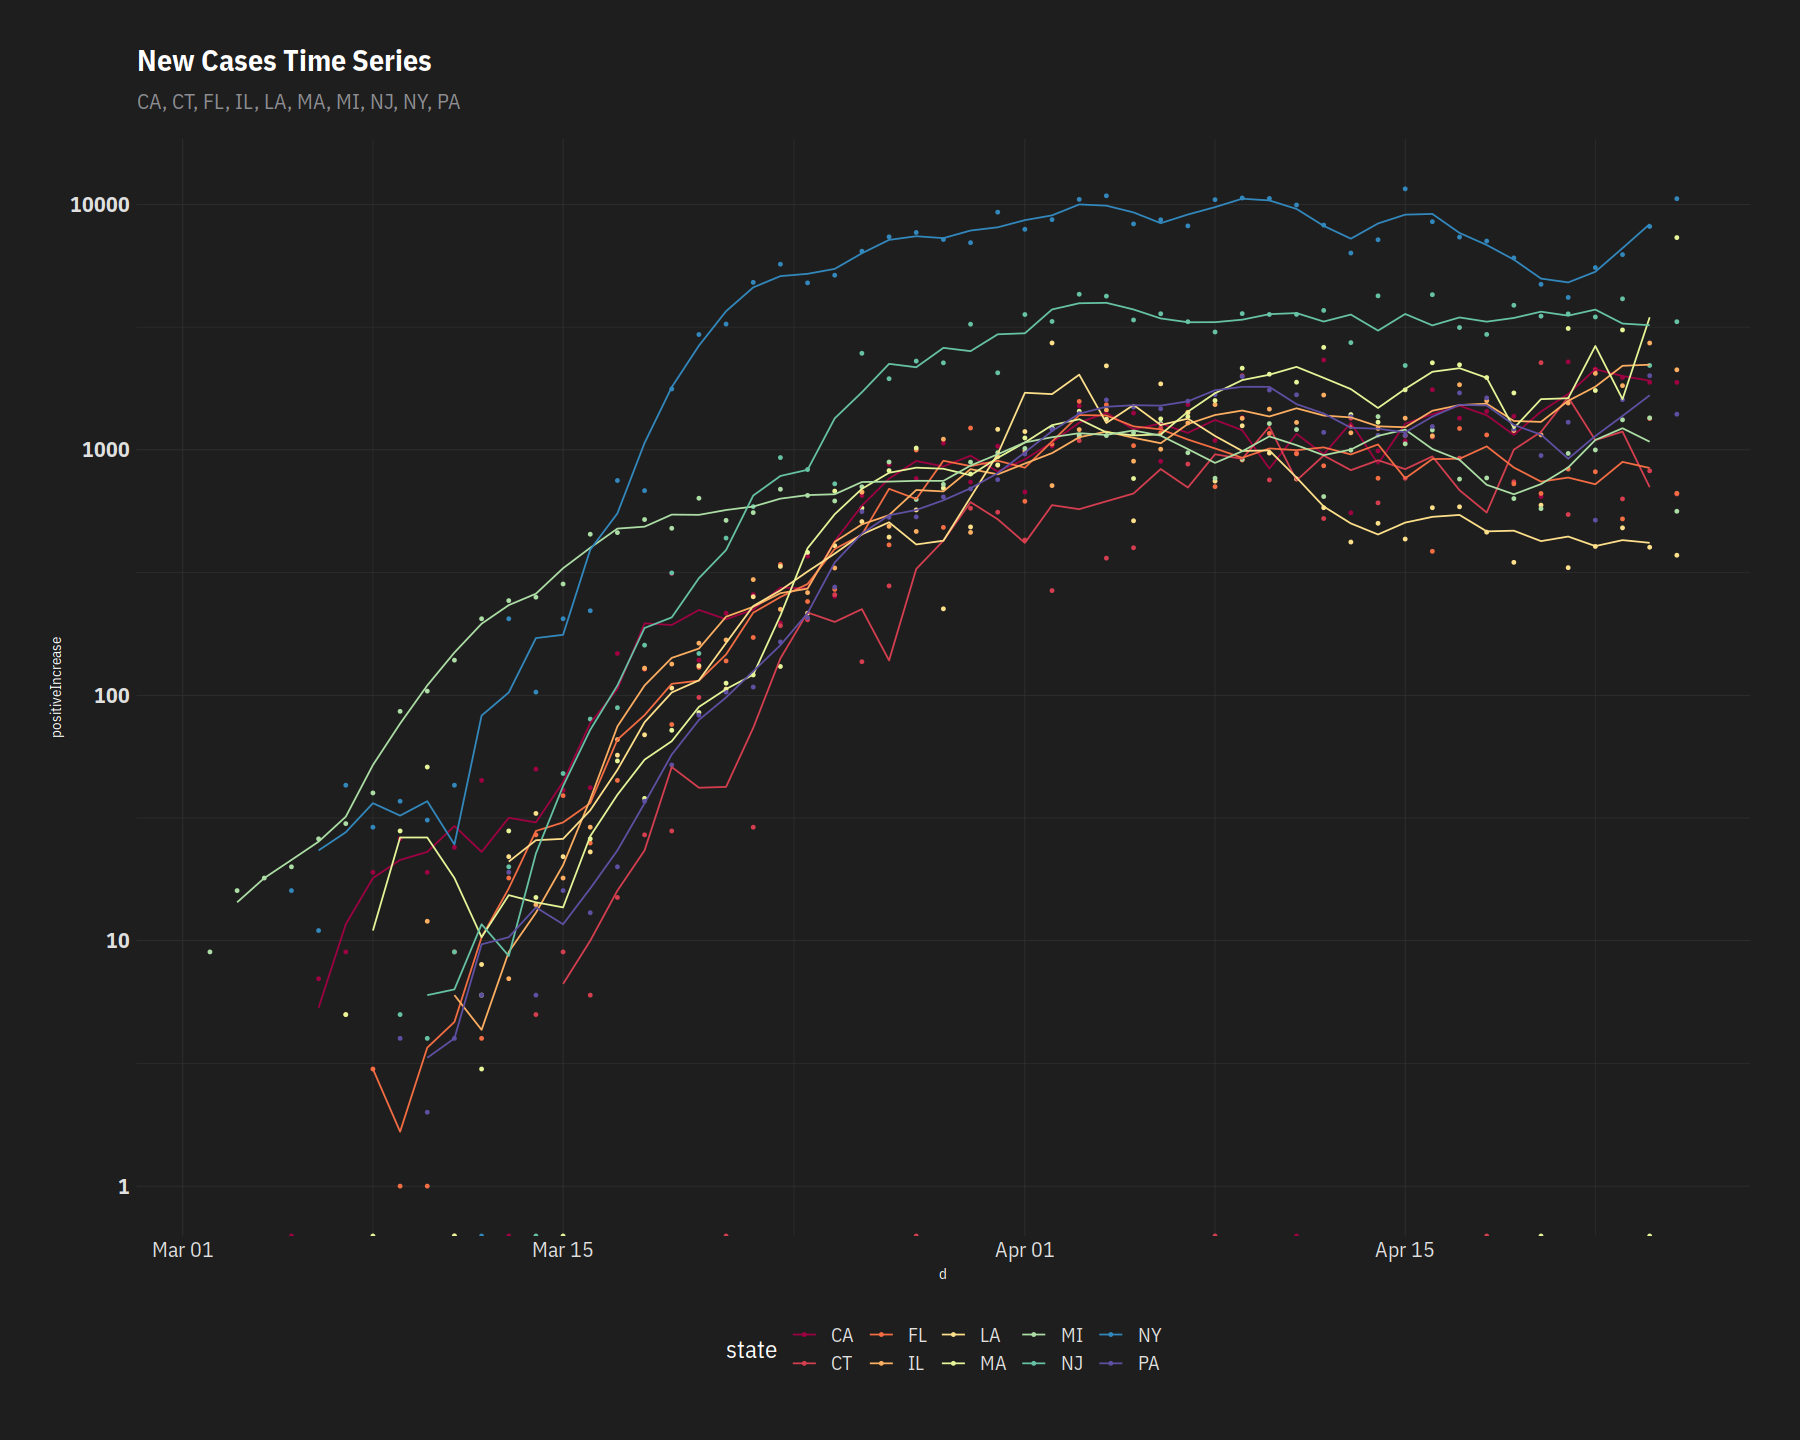

In [27]:
(p = plot_ts(t10states, 'positiveIncrease', "New Cases Time Series", T))

In [ ]:
embed_notebook(ggplotly(p))

## Tests 

Warning message:
“Removed 20 row(s) containing missing values (geom_path).”


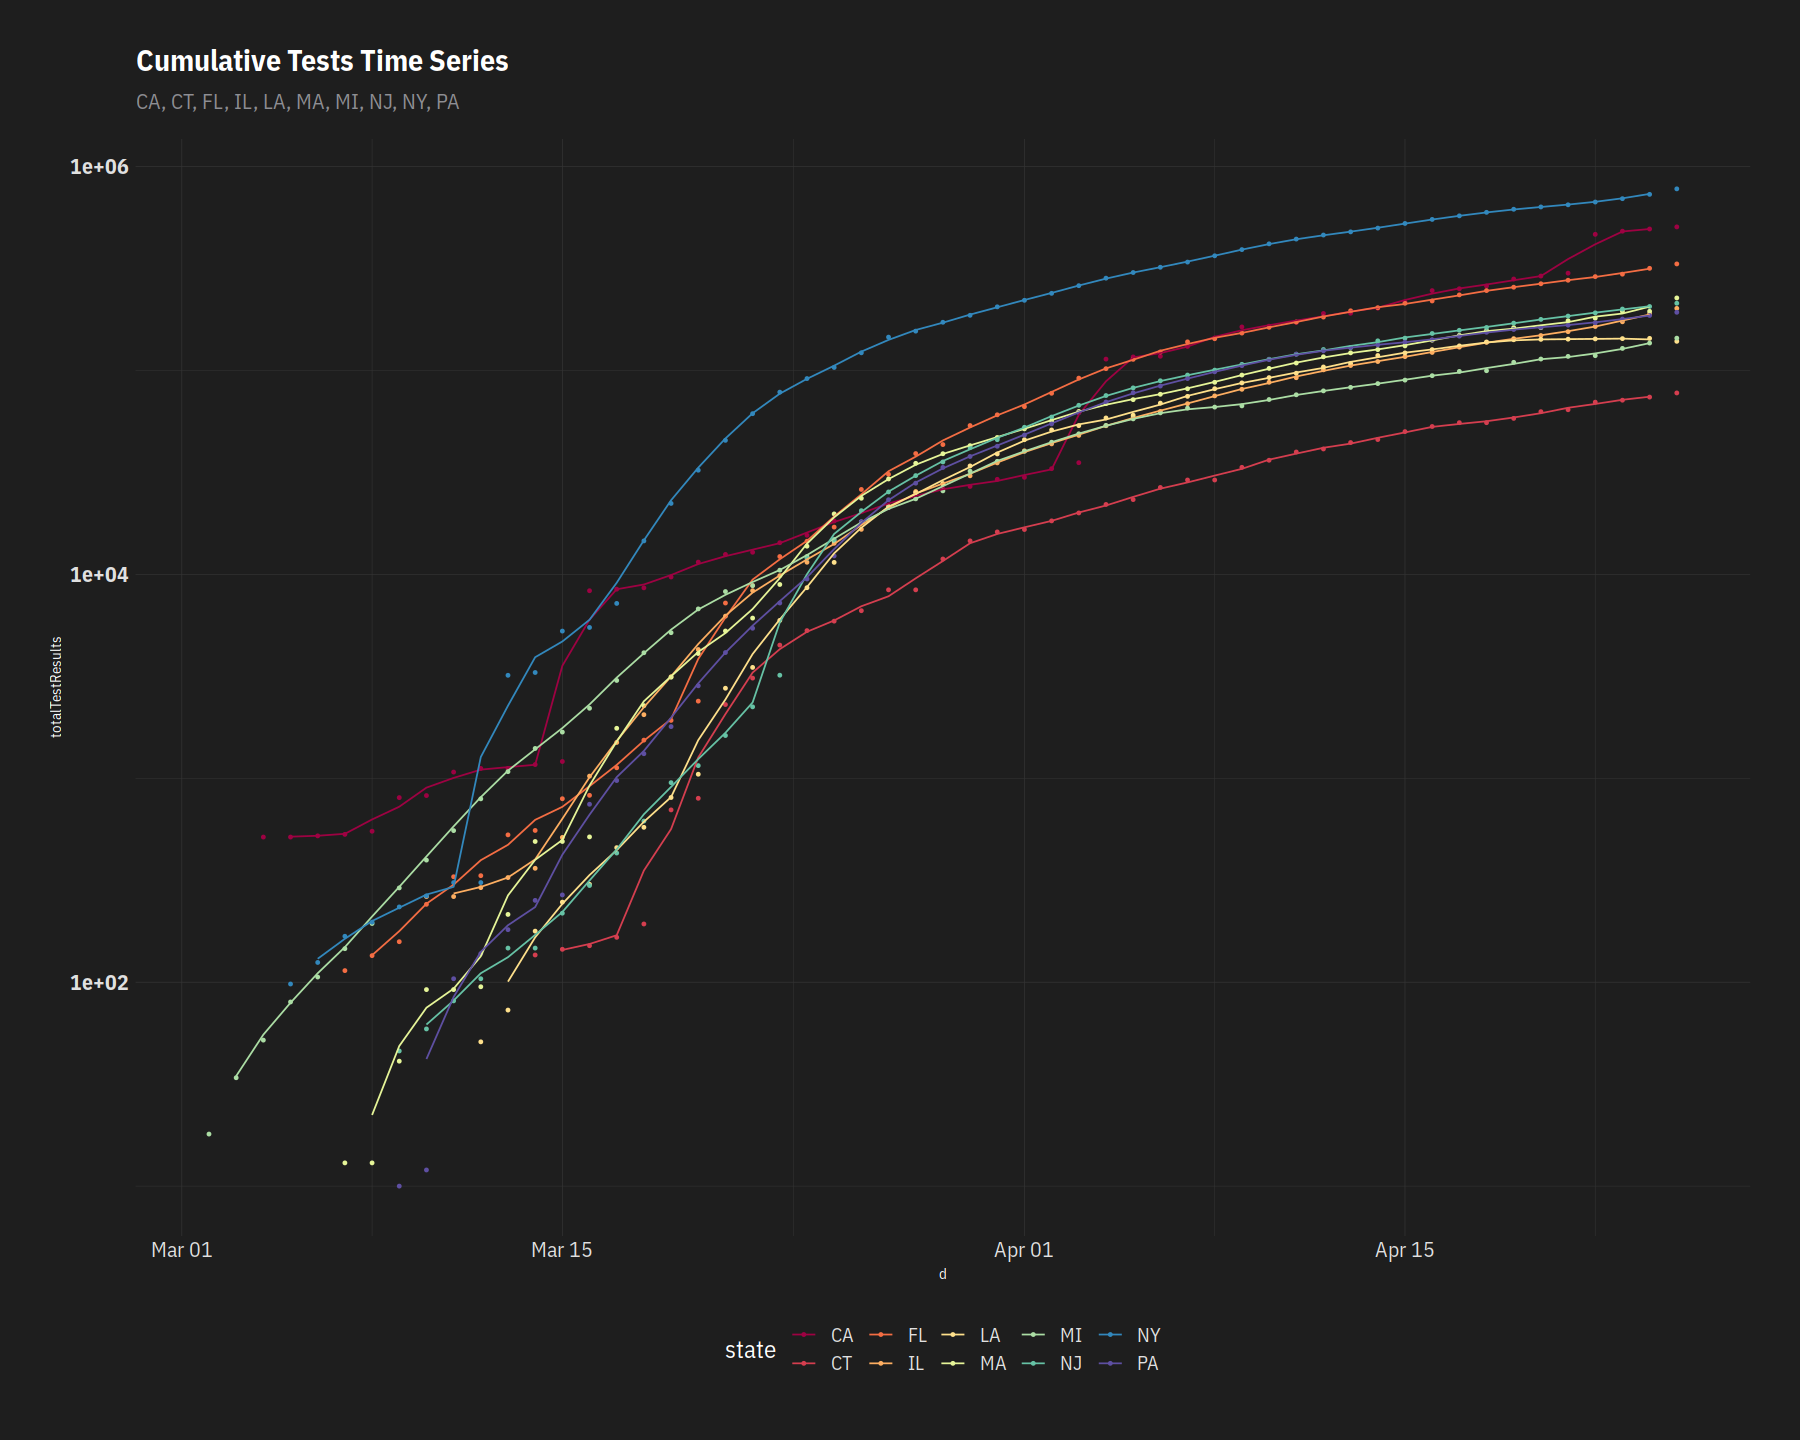

In [28]:
(p = plot_ts(t10states, 'totalTestResults', "Cumulative Tests Time Series", T))

In [ ]:
embed_notebook(ggplotly(p))

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 11 row(s) containing missing values (geom_path).”


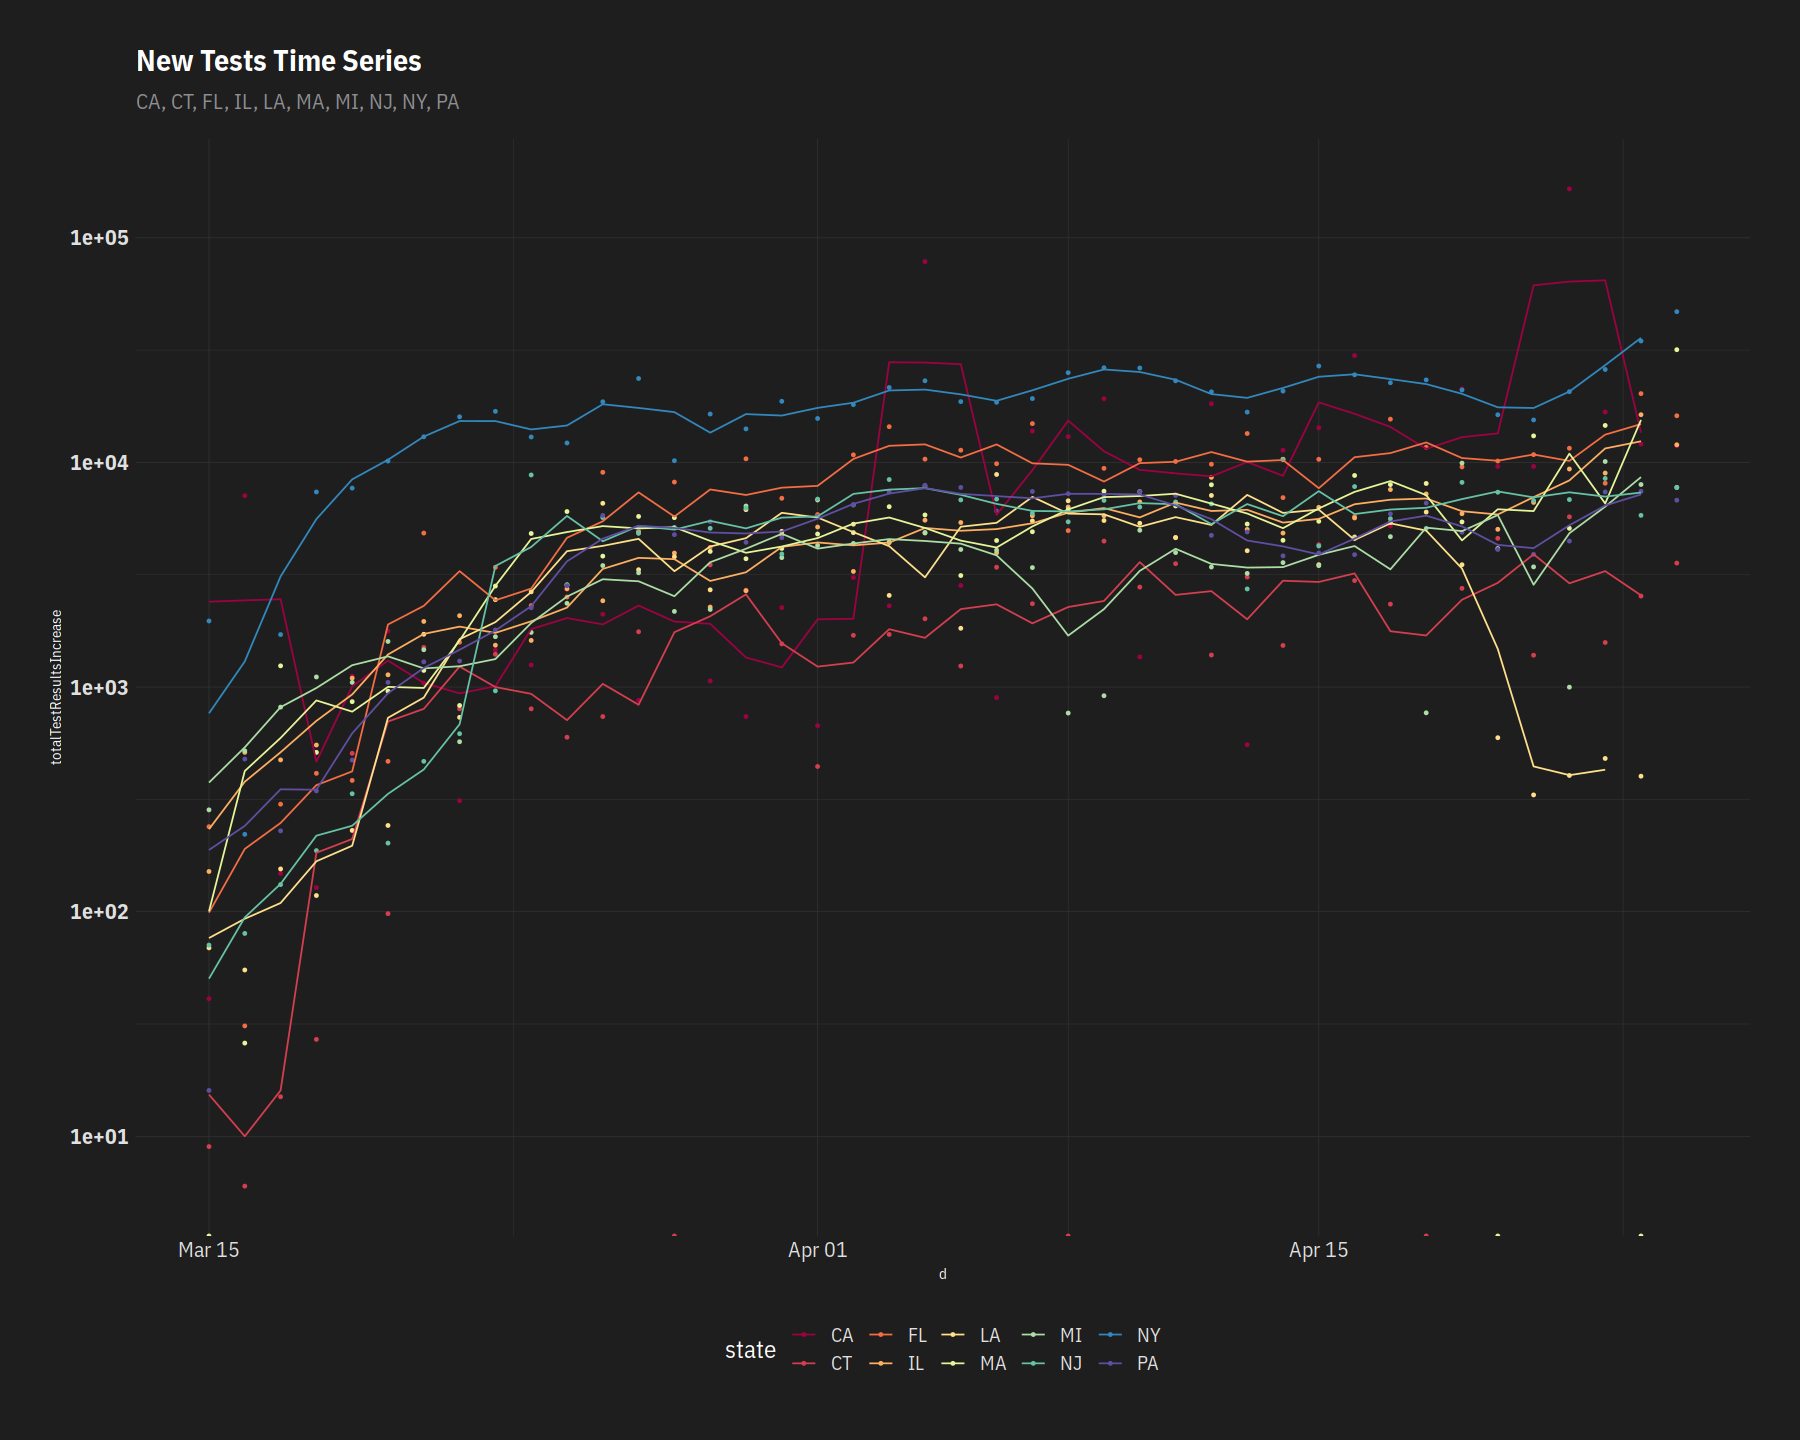

In [29]:
(p = plot_ts(t10states[d >= '2020-03-15'], 'totalTestResultsIncrease', "New Tests Time Series", T))

## TPR

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 20 row(s) containing missing values (geom_path).”


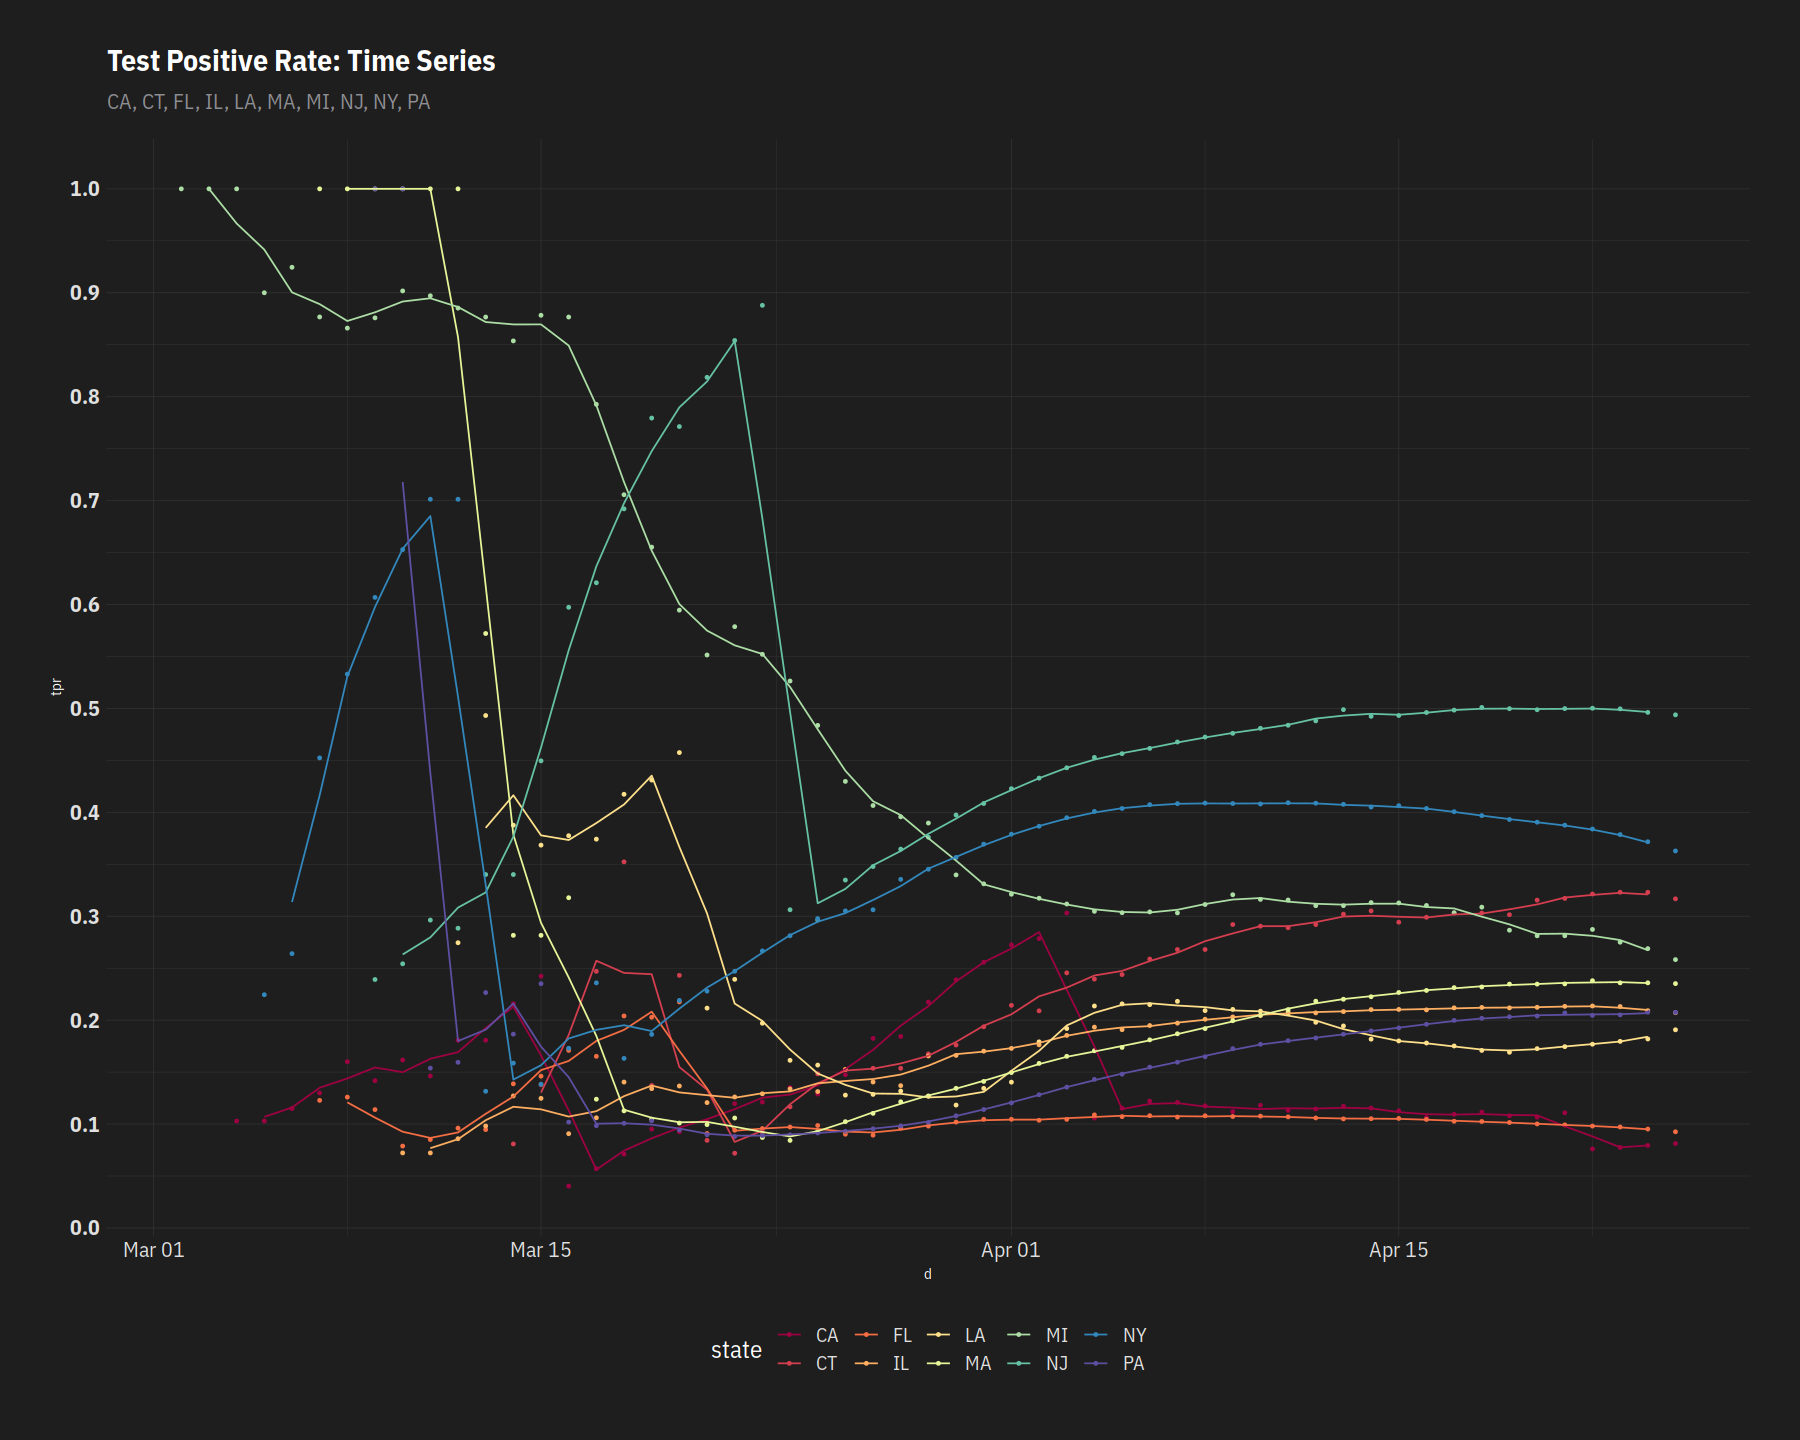

In [30]:
p1 = plot_ts(t10states, 'tpr', "Test Positive Rate: Time Series", T) +
    scale_y_continuous(breaks = seq(0, 1, .1))
# p2 = plot_ts(t10states, rm3_tpr, "Test Positive Rate (Rolling Mean): Time Series", T) +
#     scale_y_continuous(breaks = seq(0, 1, .1))
p1 

### TPR Over time (interactive)

In [ ]:
embed_notebook(ggplotly(p1))

## New TPR

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 31 row(s) containing missing values (geom_path).”


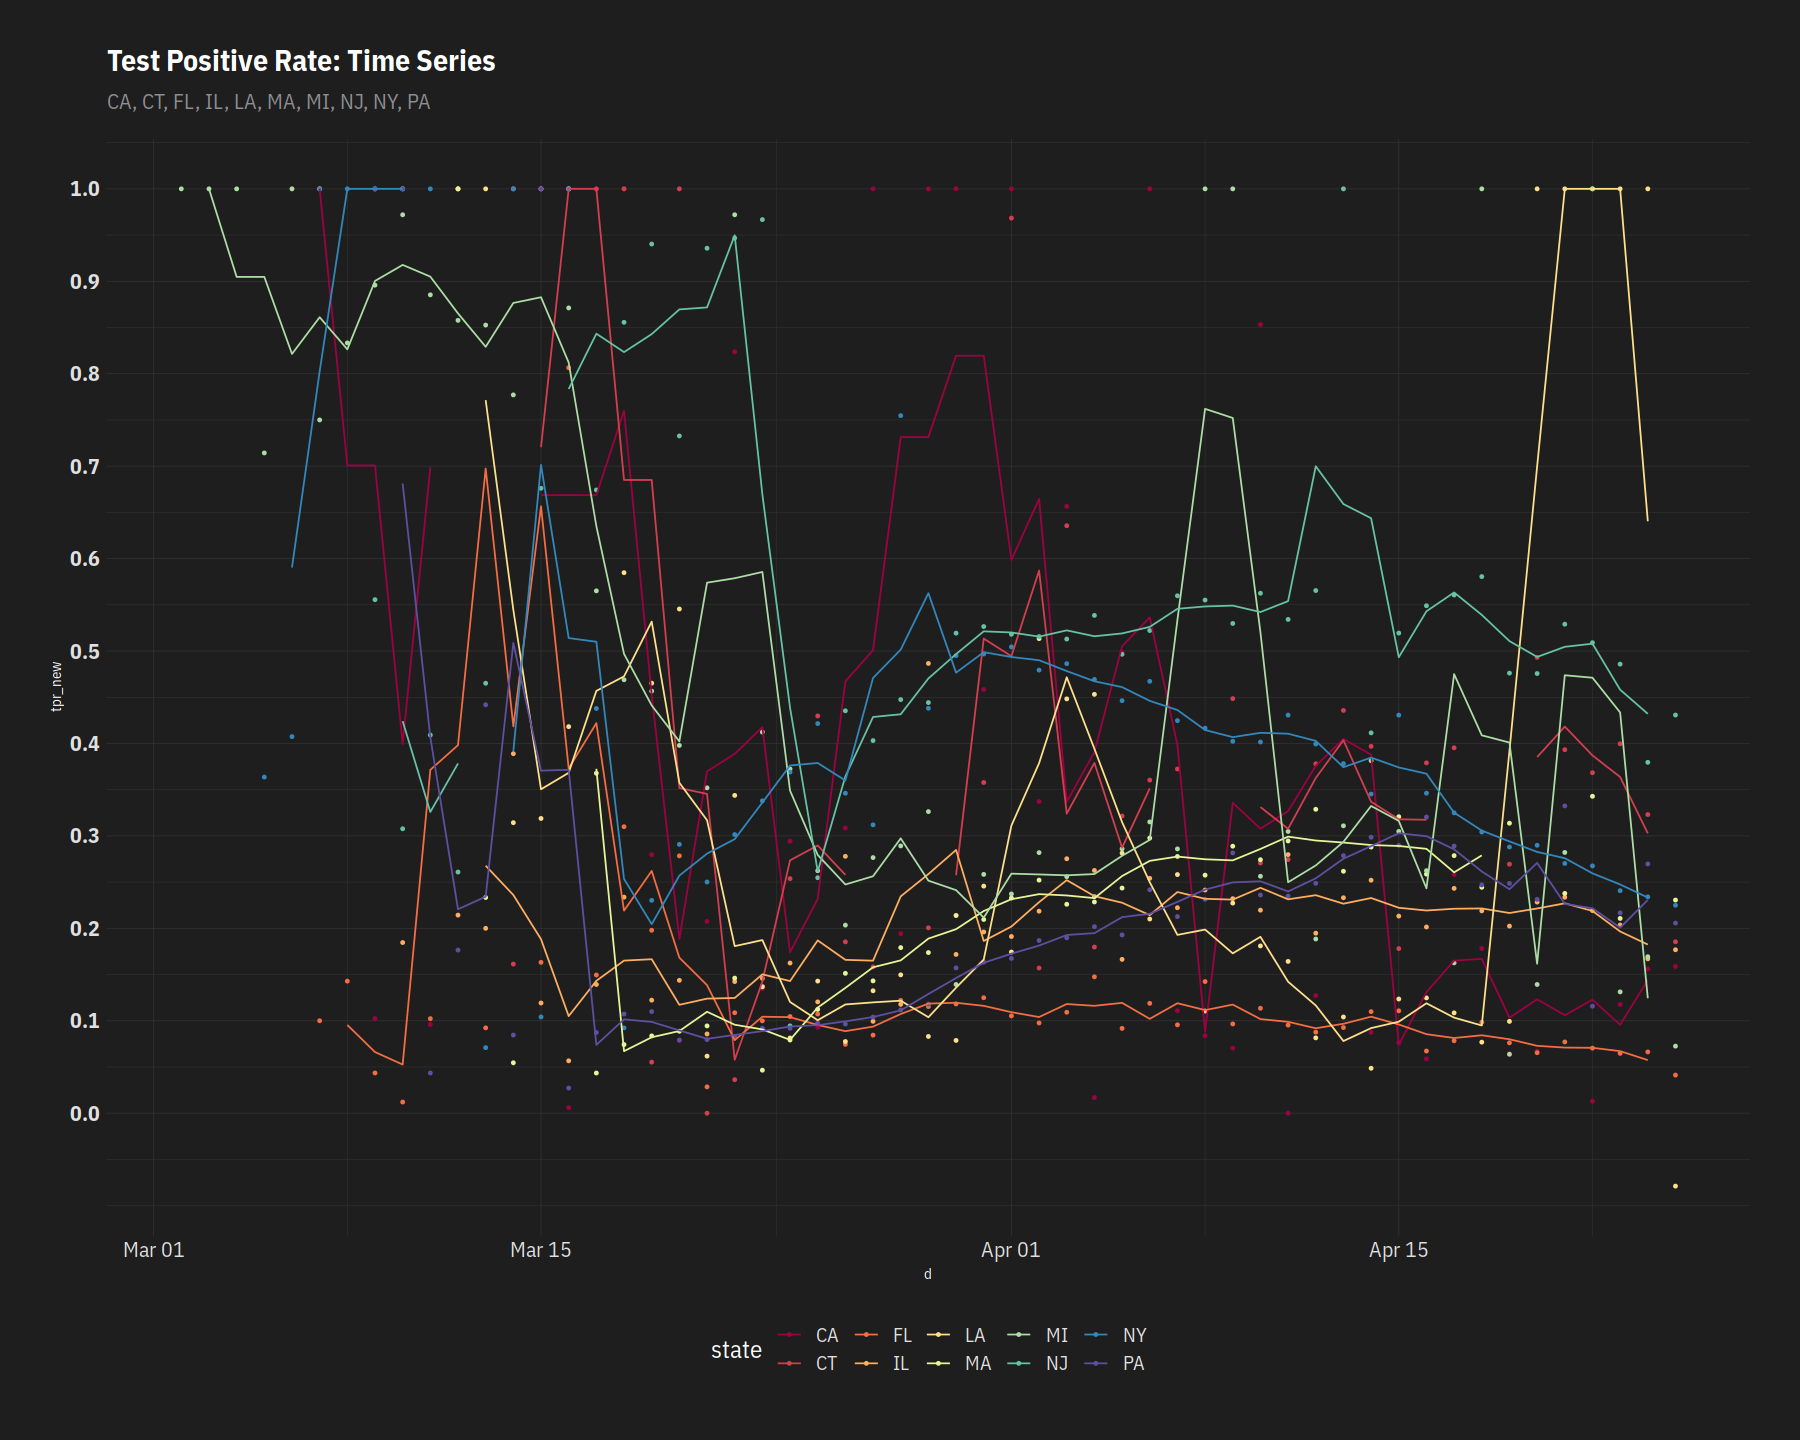

In [31]:
p1 = plot_ts(t10states, 'tpr_new', "Test Positive Rate: Time Series", T) +
    scale_y_continuous(breaks = seq(0, 1, .1))

p1 

In [ ]:
embed_notebook(ggplotly(p2))

# Day-of-week effects 

In [32]:
dt = t10states[d >= '2020-03-15']
dt[, wknd := ifelse(day %in% c("Saturday", "Sunday"), 1, 0)]
dt[, t := date - 20200315] # time trend 
dt$day2 = as.factor(dt$day) 
dt %>% head()

date     state positive negative pending hospitalizedCurrently
1 20200315 CA     293       916    NA      NA                   
2 20200316 CA     335      7981    NA      NA                   
3 20200317 CA     483      7981    NA      NA                   
4 20200318 CA     611      7981    NA      NA                   
5 20200319 CA     924      8787    NA      NA                   
6 20200320 CA    1063     10424    NA      NA                   
  hospitalizedCumulative inIcuCurrently inIcuCumulative onVentilatorCurrently ⋯
1 NA                     NA             NA              NA                    ⋯
2 NA                     NA             NA              NA                    ⋯
3 NA                     NA             NA              NA                    ⋯
4 NA                     NA             NA              NA                    ⋯
5 NA                     NA             NA              NA                    ⋯
6 NA                     NA             NA              NA                    ⋯
  rm3_totalTestResults rm3_positiveIncrease rm3_hospitalizedIncrease
1  3564                 44.33               0                       
2  5996                 77.00               0                       
3  8457                106.00               0                       
4  8922                196.33               0                       
5  9930                193.33               0                       
6 11242                222.67               0                       
  rm3_deathIncrease rm3_totalTestResultsIncrease rm3_tpr rm3_tpr_new wknd t
1 0.6667            2399                         0.16613 0.6686      1    0
2 2.0000            2432                         0.11323 0.6686      0    1
3 2.6667            2461                         0.05615 0.6686      0    2
4 4.0000             465                         0.07444 0.7599      0    3
5 3.0000            1008                         0.08627 0.4527      0    4
6 3.6667            1312                         0.09659 0.1885      0    5
  day2     
1 Sunday   
2 Monday   
3 Tuesday  
4 Wednesday
5 Thursday 
6 Friday

Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


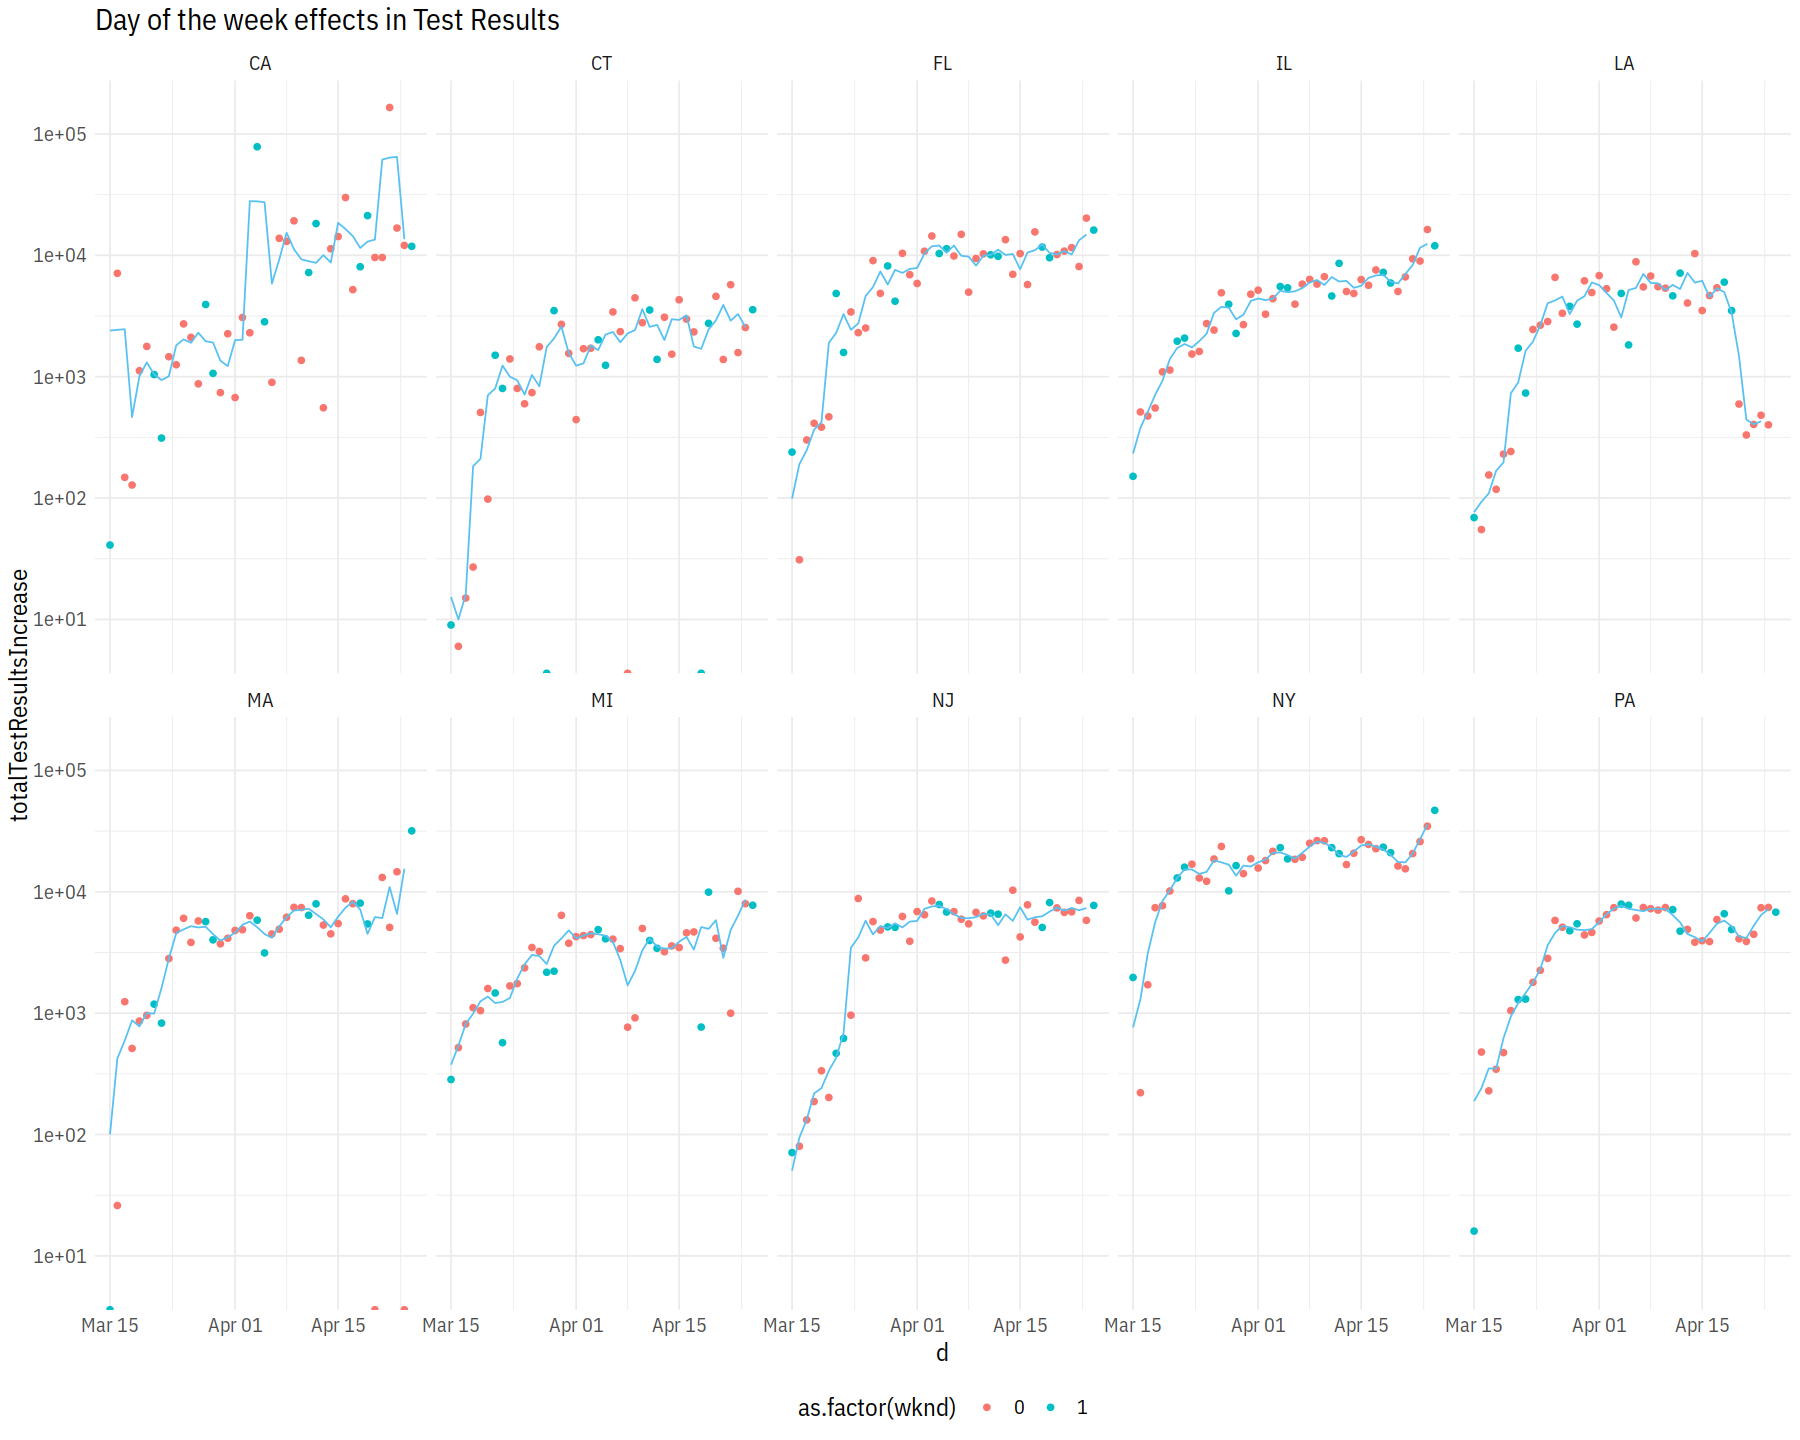

In [33]:
(p = ggplot(dt, aes(d)) +
    geom_point(aes(y = totalTestResultsIncrease, colour = as.factor(wknd))) + 
    geom_line(aes(y = rm3_totalTestResultsIncrease)) +
    labs(title = "Day of the week effects in Test Results") +
    facet_wrap(~ state, 2) +
    lal_plot_theme() +
    scale_y_log10()
)

In [34]:
day_of_week_plot = function(df){
    d = df %>% filter(term != "(Intercept)") %>% 
        mutate(day = str_replace(term, "relevel\\(day2, 2\\)", "")) %>% 
        mutate(ord_day = case_when(
            day == "Monday" ~ 1,  day == "Tuesday" ~ 2,  day == "Wednesday" ~ 3,  day == "Thursday" ~ 4, 
            day == "Friday" ~ 5,  day == "Saturday" ~ 6,  day == "Sunday" ~ 7
        ), wknd = as.factor(ifelse(day %in% c("Saturday", "Sunday"), 1, 0))) %>% 
        mutate(ub = estimate + 1.96 * `std.error`, 
               lb = estimate - 1.96 * `std.error`)
    stname = unique(df$state)
    p = ggplot(d, aes(x = ord_day,y = estimate, colour = wknd)) +
        geom_point() + 
        theme(legend.position = "None") +
        geom_pointrange(aes(ymin = lb, ymax = ub)) + 
        labs(title = stname)
}

Warning message in log(totalTestResultsIncrease + 1):
“NaNs produced”


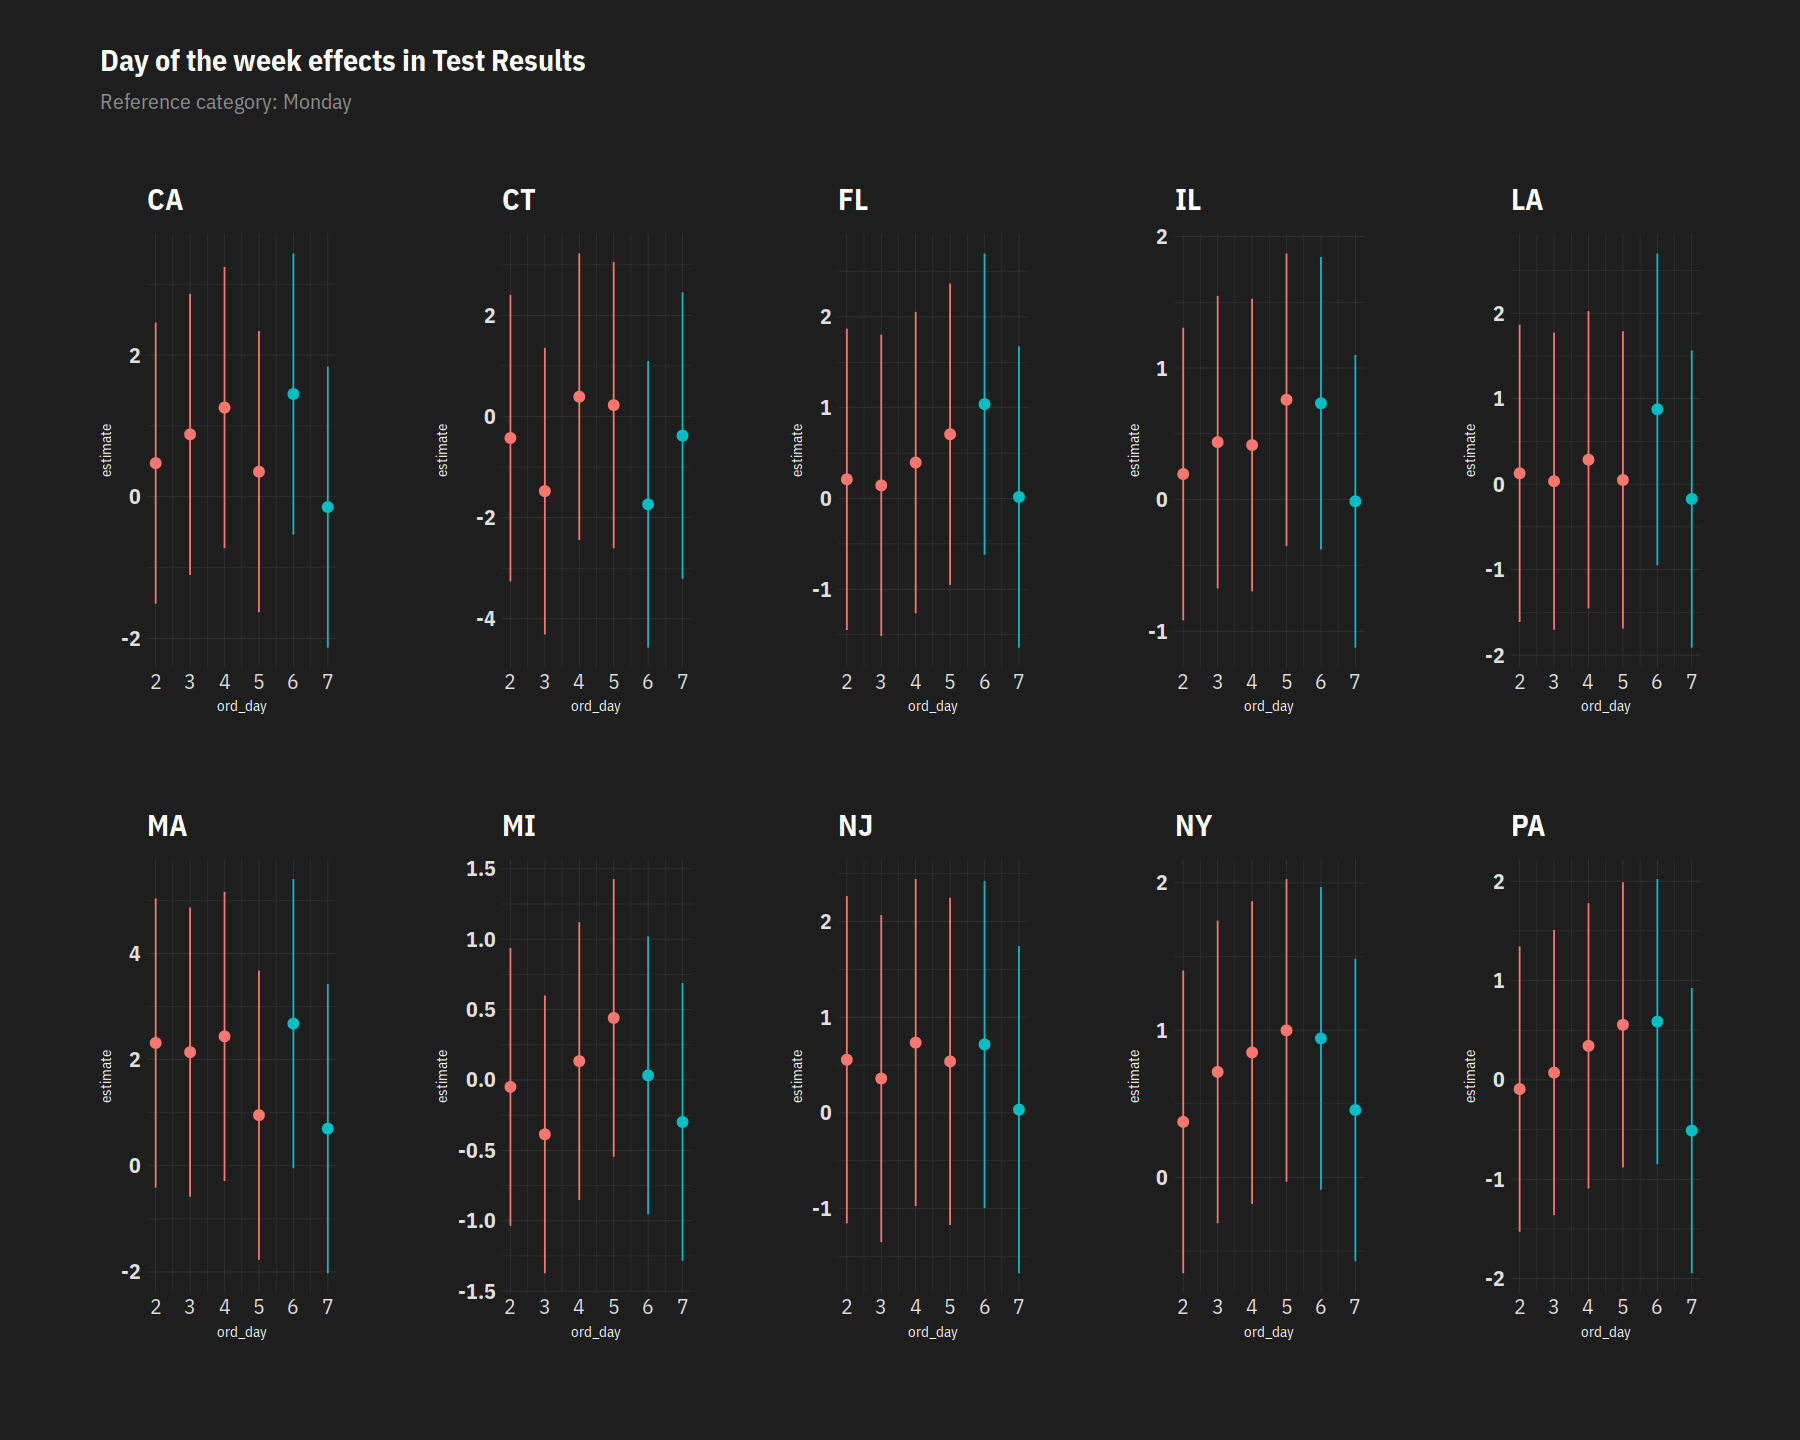

In [35]:
test_increase_regs = dt %>% group_by(state) %>% group_map( ~ lm(log(totalTestResultsIncrease+1) ~ relevel(day2, 2), .x) %>% tidy %>% mutate(state = .y[[1]]), keep = T) 
dow_plots = map(test_increase_regs , day_of_week_plot) %>% wrap_plots(nrow = 2)
dow_plots +  plot_annotation(
    title = 'Day of the week effects in Test Results',
    subtitle = 'Reference category: Monday',
)

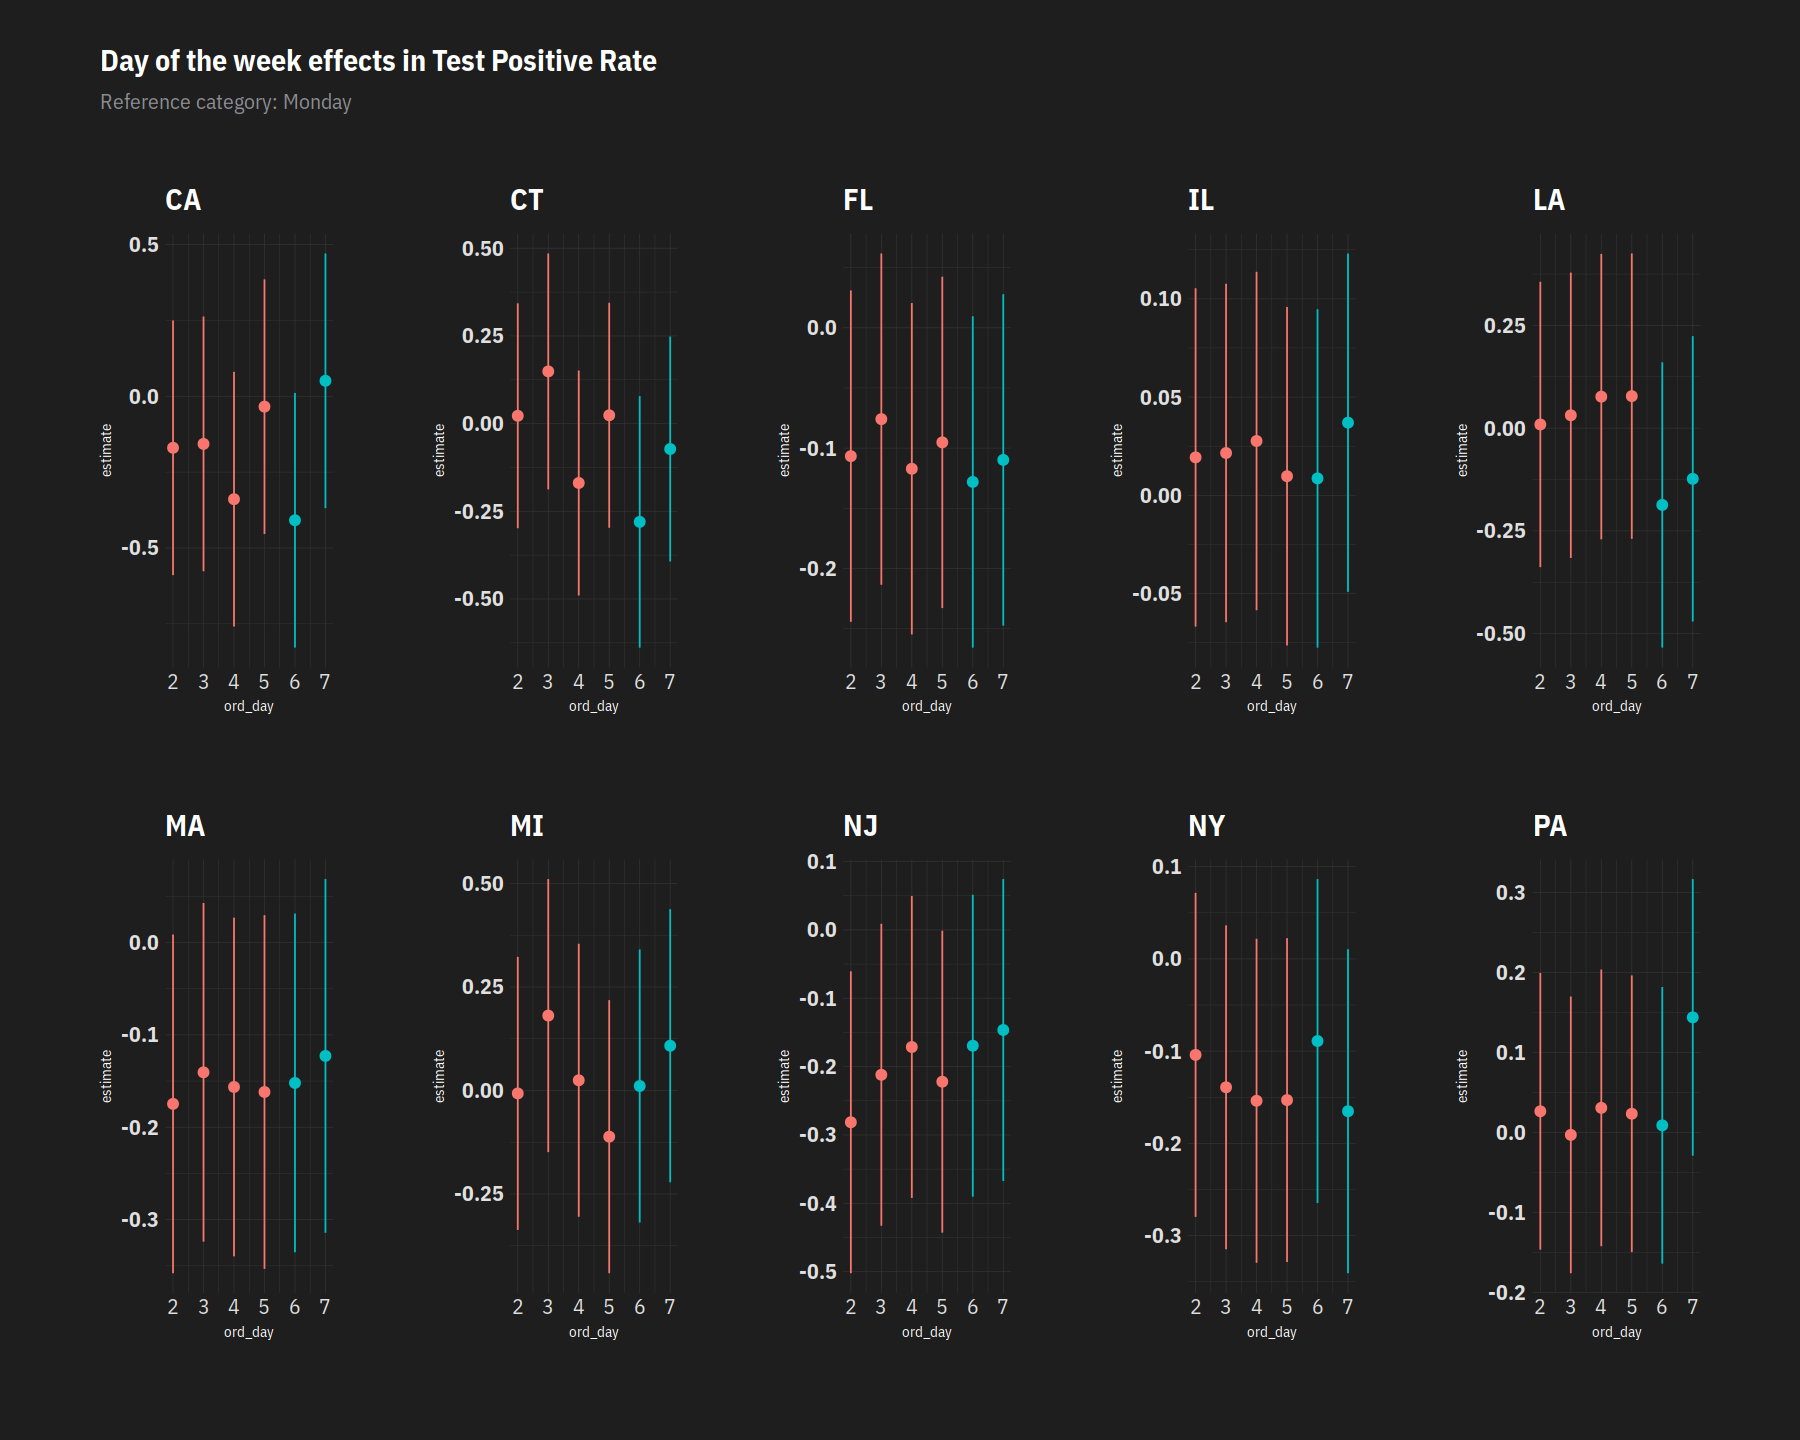

In [36]:
positive_rate = dt %>% group_by(state) %>% group_map( ~ lm(tpr_new ~ relevel(day2, 2), .x) %>% tidy %>% mutate(state = .y[[1]]), keep = T) 
dow_plots = map(positive_rate, day_of_week_plot) %>% wrap_plots(nrow = 2)
dow_plots +  plot_annotation(
    title = 'Day of the week effects in Test Positive Rate',
    subtitle = 'Reference category: Monday',
)

Warning message in log(deathIncrease + 1):
“NaNs produced”


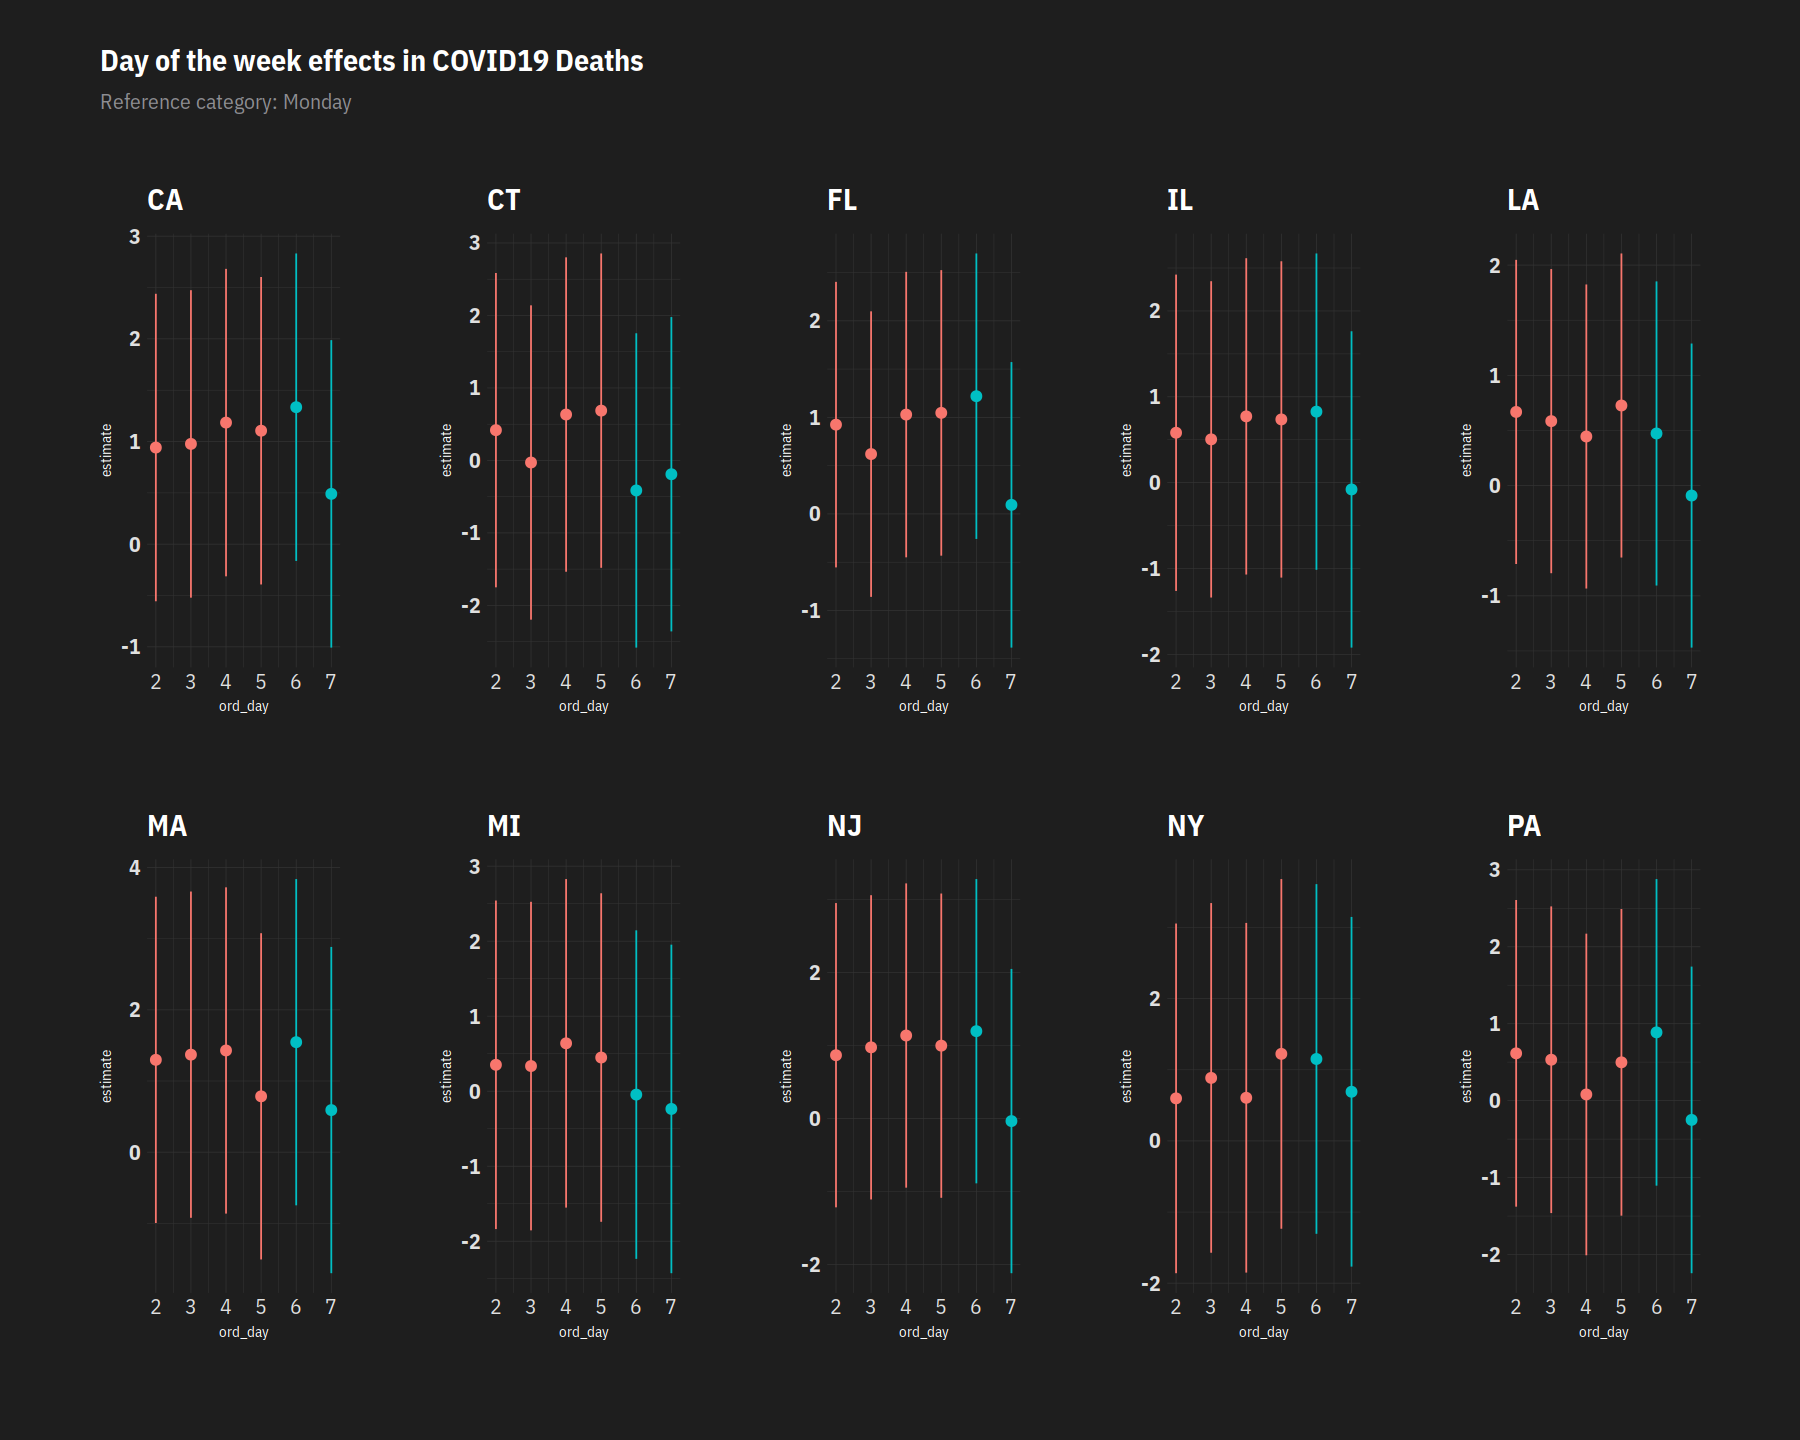

In [37]:
dths = dt %>% group_by(state) %>% group_map( ~ lm(log(deathIncrease+1) ~ relevel(day2, 2), .x) %>% tidy %>% mutate(state = .y[[1]]), keep = T) 
dow_plots = map(dths, day_of_week_plot) %>% wrap_plots(nrow = 2)
dow_plots +  plot_annotation(
    title = 'Day of the week effects in COVID19 Deaths',
    subtitle = 'Reference category: Monday',
)